In [1]:
import pandas as pd
import numpy as np
import talib
from utils import utils
import os
from alpha_vantage.timeseries import TimeSeries

%matplotlib inline

In [3]:
df = pd.read_csv('../data/MELI.csv')
df

,date,1. open,2. high,3. low,4. close,5. volume
0,2021-08-25,1860.87,1872.3000,1844.450,1871.94,260338.0
1,2021-08-24,1834.38,1865.8900,1825.095,1855.29,357964.0
2,2021-08-23,1793.01,1817.4850,1771.210,1810.00,427292.0
3,2021-08-20,1756.00,1799.4775,1753.500,1786.54,232104.0
4,2021-08-19,1762.00,1804.8900,1746.020,1759.96,319970.0
...,...,...,...,...,...,...
3531,2007-08-16,28.25,30.0000,25.060,28.10,1107495.0
3532,2007-08-15,30.21,30.2100,28.050,28.56,991764.0
3533,2007-08-14,32.45,32.7000,29.980,30.03,608688.0
3534,2007-08-13,31.20,39.6700,29.000,31.65,3162020.0


In [4]:
replace_columns = {
    '1. open':'open',
    '2. high':'high',
    '3. low':'low',
    '4. close':'close',
    '5. volume':'volume'
}

df = utils.rename_columns_and_format(df, replace_columns)
df = utils.get_all_indicators(df)

df.dropna(inplace=True)
df

,date,open,high,low,close,volume,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,macd,macd_signal,macd_hist,k,d
33,2007-09-27,38.50,39.9200,35.7600,36.9200,380347.0,62.590214,35.140987,32.859008,41.155153,31.936500,22.717847,2.266827,1.011364,1.255463,52.149090,73.108954
34,2007-09-28,36.23,38.0000,35.3700,36.2601,1570642.0,60.368836,35.313159,33.110941,41.592495,32.312005,23.031515,2.189396,1.246970,0.942426,33.004315,54.157867
35,2007-10-01,36.63,39.2400,35.5601,36.7101,227623.0,61.375530,35.528073,33.377545,42.001298,32.741510,23.481722,2.139679,1.425512,0.714167,22.255978,35.803128
36,2007-10-02,37.63,40.0000,37.2400,39.4000,304178.0,66.803757,36.123754,33.823653,42.735670,33.311510,23.887350,2.290921,1.598594,0.692327,43.685883,32.982059
37,2007-10-03,39.16,42.7900,38.5700,42.1200,382969.0,71.209878,37.046253,34.438197,43.884910,33.992010,24.099110,2.600289,1.798933,0.801356,69.005960,44.982607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,2021-08-19,1762.00,1804.8900,1746.0200,1759.9600,319970.0,57.660557,1764.293981,1696.483305,1935.620661,1710.834250,1486.047839,67.810677,69.661896,-1.851219,18.514225,25.091995
3532,2021-08-20,1756.00,1799.4775,1753.5000,1786.5400,232104.0,60.066534,1767.716446,1703.154171,1941.943457,1719.470750,1496.998043,64.562275,68.641972,-4.079697,25.072757,21.601890
3533,2021-08-23,1793.01,1817.4850,1771.2100,1810.0000,427292.0,62.112954,1774.221608,1711.068677,1947.599442,1730.685250,1513.771058,63.152931,67.544164,-4.391233,45.738433,29.775138
3534,2021-08-24,1834.38,1865.8900,1825.0950,1855.2900,357964.0,65.760829,1786.693668,1721.751738,1956.246777,1744.449750,1532.652723,64.941930,67.023717,-2.081787,71.885199,47.565463


## Prueba utilizando indicadores individuales como inputs

In [5]:
WINDOW = 30
P_TRAIN = 0.8
EPOCHS = 100
BATCH_SIZE = 32

### Hacemos un head 500 pq solo es para pruebas

In [ ]:
#df = df.head(50)

In [6]:
#Elimino metricas viejas antes de escribir las nuevas

metric_files = os.listdir('../metrics')
if metric_files:
    for file in metric_files:
        os.remove('../metrics/' + file)

In [7]:
columns = ['ema_12', 'ema_26', 'upper_bband', 
         'middle_bband', 'lower_bband', 'rsi', 
         'macd', 'macd_signal', 'macd_hist', 'k', 'd']

target_column = df['close'].to_numpy()
for column in columns:
    df_min = df[column]
    x, y = utils.create_windowed_dataset(df_min, target_column, WINDOW)
    x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)
    
    _, x_input, y_input = x.shape
    model = utils.get_model(x_input, y_input)
    
    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)
    
    history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test,y_test), 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    verbose=0)
    
    df_history = pd.DataFrame(history.history)
    df_history.to_csv(f'../metrics/{column}.csv', index=False) 

In [8]:
df_metrics = utils.get_input_based_performance()
df_metrics

,loss,val_loss,root_mean_squared_error,val_root_mean_squared_error
ema_26,1688.965124,49635.589456,41.097019,222.790451
middle_bband,1995.335481,50858.380564,44.669182,225.518036
macd,2505.150520,74876.474404,50.051479,273.635651
macd_signal,2795.677603,104993.703473,52.874168,324.027313
ema_12,1402.743180,106301.420549,37.453213,326.039001
lower_bband,2260.887157,122822.584442,47.548790,350.460541
upper_bband,1568.603024,131423.042311,39.605595,362.523132
macd_hist,2403.124057,133488.821982,49.021664,365.361206
rsi,6221.318422,922103.744604,78.875336,960.262329
k,3197.294654,925670.456115,56.544628,962.117737


## Prueba utilizando todos los indicadores

In [9]:
df_min = df[columns]

x, y = utils.create_windowed_dataset(df_min, df['close'].to_numpy(), WINDOW)
x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)

_, x_input, y_input = x.shape
model = utils.get_model(x_input, y_input)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

history = model.fit(x_train, 
                y_train, 
                validation_data=(x_test,y_test), 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS,
                verbose=0)

df_history = pd.DataFrame(history.history)
df_history.to_csv(f'../metrics/all_indicators.csv', index=False)

#evaluacion del modelo
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)

print(f'Perdida en train: {train_score[0]}, RMSE en train: {train_score[1]}')
print(f'Perdida en test: {test_score[0]}, RMSE en test: {test_score[1]}')

Perdida en train: 2146.8975295169134, RMSE en train: 46.334625244140625
Perdida en test: 130533.06794064748, RMSE en test: 361.2936096191406


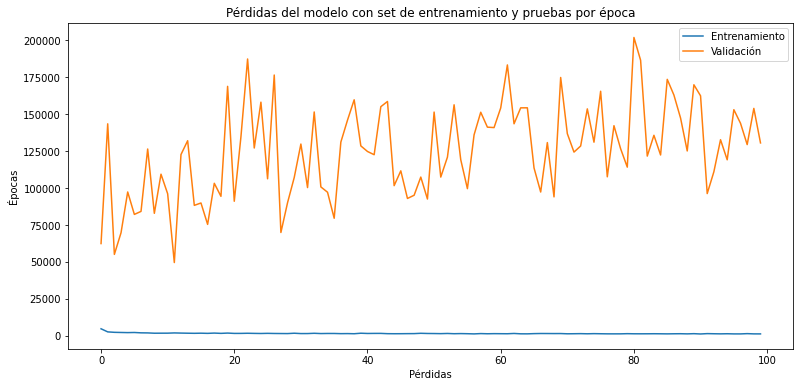

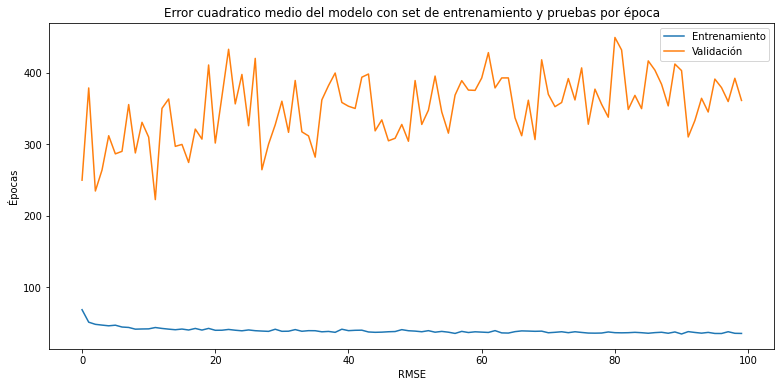

In [10]:
x1 = model.history.history['loss']
x2 = model.history.history['val_loss']
title = "Pérdidas del modelo con set de entrenamiento y pruebas por época"
ylabel = 'Pérdidas'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

x1 = model.history.history['root_mean_squared_error']
x2 = model.history.history['val_root_mean_squared_error']
title = "Error cuadratico medio del modelo con set de entrenamiento y pruebas por época"
ylabel = 'RMSE'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

## Prueba utilizando los indicadores de tipo oscilador 

In [11]:
columns = ['rsi', 'macd', 'macd_signal', 'macd_hist', 'k', 'd']

df_min = df[columns]

x, y = utils.create_windowed_dataset(df_min, df['close'].to_numpy(), WINDOW)
x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)

_, x_input, y_input = x.shape
model = utils.get_model(x_input, y_input)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

history = model.fit(x_train, 
                y_train, 
                validation_data=(x_test,y_test), 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS,
                verbose=0)

df_history = pd.DataFrame(history.history)
df_history.to_csv(f'../metrics/oscillator_indicators.csv', index=False)

#evaluacion del modelo
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)

print(f'Perdida en train: {train_score[0]}, RMSE en train: {train_score[1]}')
print(f'Perdida en test: {test_score[0]}, RMSE en test: {test_score[1]}')

Perdida en train: 709.5913236712792, RMSE en train: 26.63815689086914
Perdida en test: 147785.52254946044, RMSE en test: 384.4288024902344


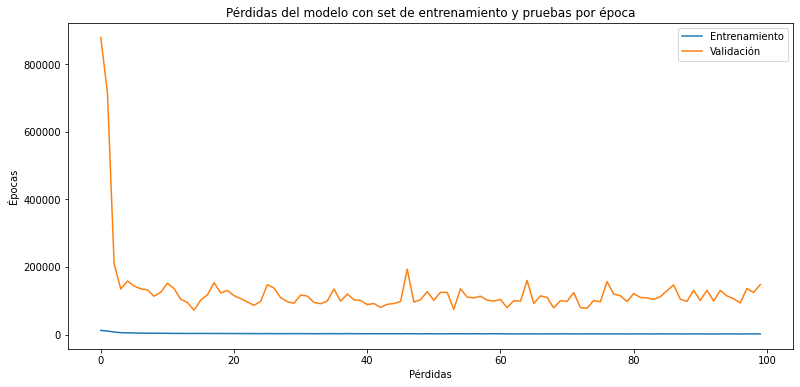

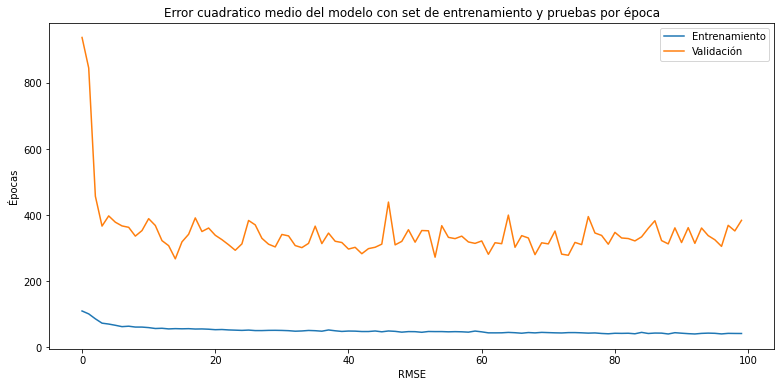

In [12]:
x1 = model.history.history['loss']
x2 = model.history.history['val_loss']
title = "Pérdidas del modelo con set de entrenamiento y pruebas por época"
ylabel = 'Pérdidas'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

x1 = model.history.history['root_mean_squared_error']
x2 = model.history.history['val_root_mean_squared_error']
title = "Error cuadratico medio del modelo con set de entrenamiento y pruebas por época"
ylabel = 'RMSE'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

## Prueba utilizando solo los indicadores de tendencia

In [13]:
columns = ['ema_12', 'ema_26', 'upper_bband', 
         'middle_bband', 'lower_bband']

df_min = df[columns]

x, y = utils.create_windowed_dataset(df_min, df['close'].to_numpy(), WINDOW)
x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)

_, x_input, y_input = x.shape
model = utils.get_model(x_input, y_input)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

history = model.fit(x_train, 
                y_train, 
                validation_data=(x_test,y_test), 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS,
                verbose=0)

df_history = pd.DataFrame(history.history)
df_history.to_csv(f'../metrics/trend_indicators.csv', index=False)

#evaluacion del modelo
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)

print(f'Perdida en train: {train_score[0]}, RMSE en train: {train_score[1]}')
print(f'Perdida en test: {test_score[0]}, RMSE en test: {test_score[1]}')

Perdida en train: 2721.8558442875837, RMSE en train: 52.17140579223633
Perdida en test: 157867.33228417265, RMSE en test: 397.3252258300781


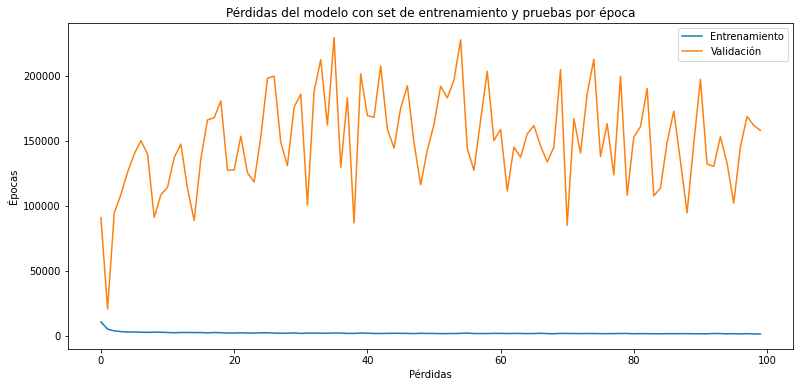

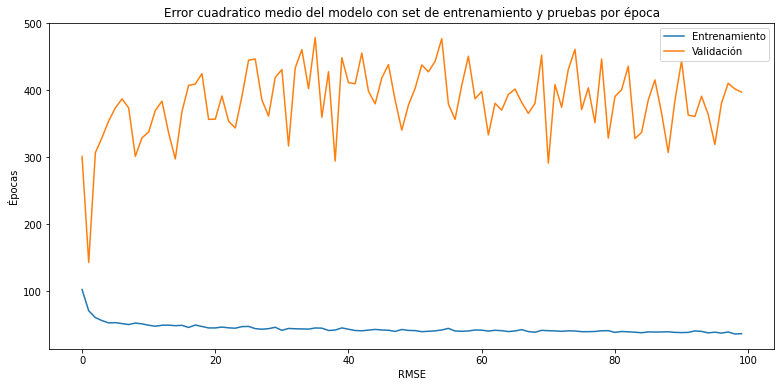

In [14]:
x1 = model.history.history['loss']
x2 = model.history.history['val_loss']
title = "Pérdidas del modelo con set de entrenamiento y pruebas por época"
ylabel = 'Pérdidas'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

x1 = model.history.history['root_mean_squared_error']
x2 = model.history.history['val_root_mean_squared_error']
title = "Error cuadratico medio del modelo con set de entrenamiento y pruebas por época"
ylabel = 'RMSE'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

In [15]:
df_metrics = utils.get_input_based_performance()
df_metrics

,loss,val_loss,root_mean_squared_error,val_root_mean_squared_error
ema_26,1688.965124,49635.589456,41.097019,222.790451
middle_bband,1995.335481,50858.380564,44.669182,225.518036
macd,2505.150520,74876.474404,50.051479,273.635651
macd_signal,2795.677603,104993.703473,52.874168,324.027313
ema_12,1402.743180,106301.420549,37.453213,326.039001
lower_bband,2260.887157,122822.584442,47.548790,350.460541
all_indicators,1262.806074,130533.067941,35.535980,361.293610
upper_bband,1568.603024,131423.042311,39.605595,362.523132
macd_hist,2403.124057,133488.821982,49.021664,365.361206
oscillator_indicators,1781.526124,147785.522549,42.208134,384.428802


In [16]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

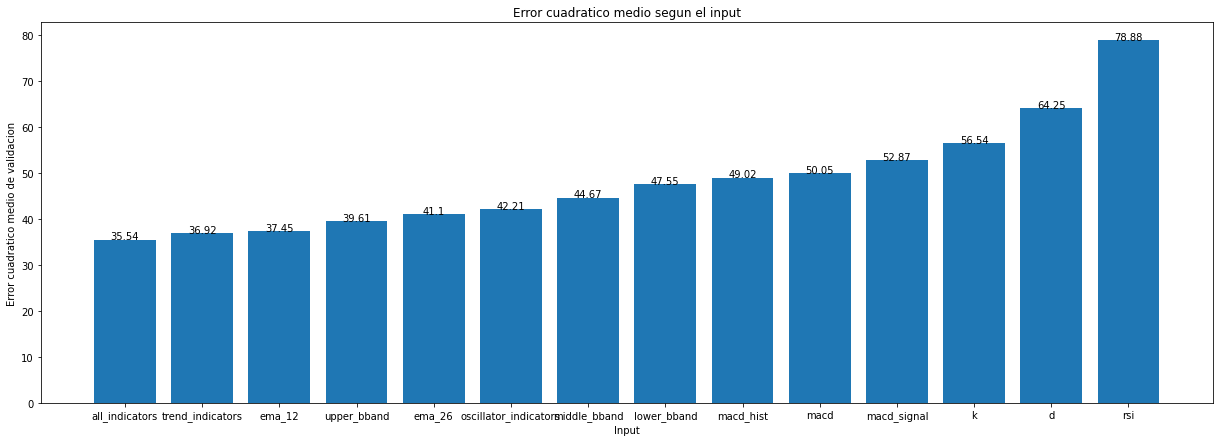

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# creating the bar plot
df_metrics.sort_values(by=['root_mean_squared_error'], inplace=True)

fig = plt.figure(figsize =(21, 7))

x, y = df_metrics.index, df_metrics['root_mean_squared_error']

plt.bar(x, y)

addlabels(x, round(y, 2))

plt.xlabel("Input")
plt.ylabel("Error cuadratico medio de validacion")
plt.title("Error cuadratico medio segun el input")
plt.show()

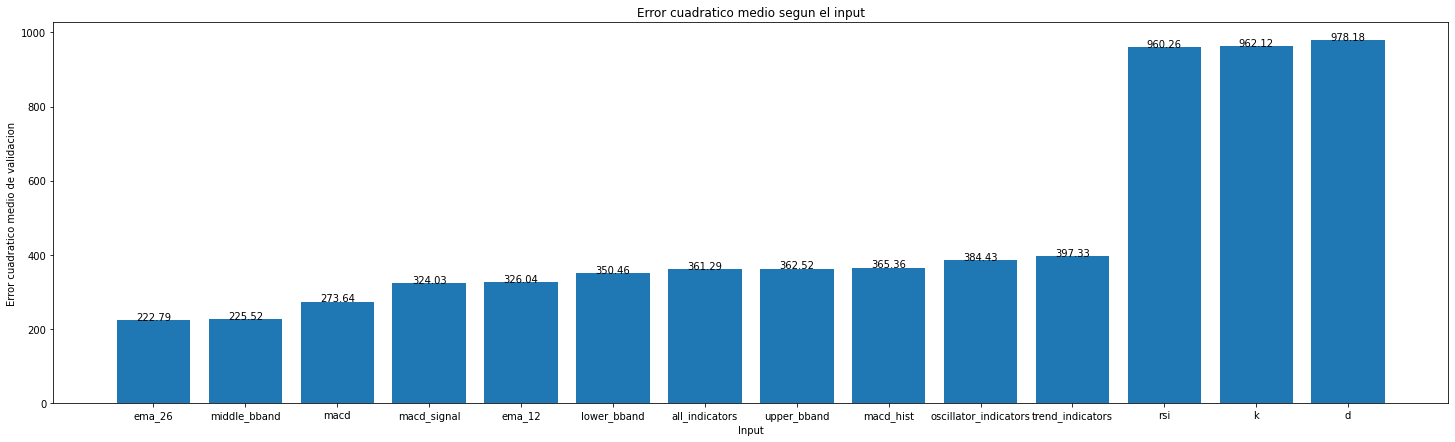

In [20]:
# creating the bar plot
# creating the bar plot
df_metrics.sort_values(by=['val_root_mean_squared_error'], inplace=True)

fig = plt.figure(figsize =(25, 7))

x, y = df_metrics.index, df_metrics['val_root_mean_squared_error']

plt.bar(x, y)

addlabels(x, round(y, 2))

plt.xlabel("Input")
plt.ylabel("Error cuadratico medio de validacion")
plt.title("Error cuadratico medio segun el input")
plt.show()